In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from simsopt.mhd import Vmec
from simsopt.geo import SurfaceRZFourier
from plotting import plot_boundaries
from utils import interpolate_coefficients

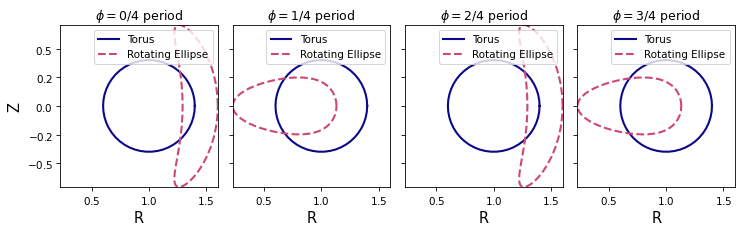

In [3]:
'''
Interpolating between torus('cold start') and precise QA 
NFP2
'''
QA_coldstart = SurfaceRZFourier.from_vmec_input('./inputs/input.nfp2_QA_cold_start')
precise_QA = SurfaceRZFourier.from_vmec_input('./inputs/input.nfp2_new_precise_QA')

QA_coldstart.change_resolution(precise_QA.mpol, precise_QA.ntor)

fig, ax = plot_boundaries(
    dpi=75,
    surfaces=[QA_coldstart, precise_QA],
    labels=["Torus", "Rotating Ellipse"],
    nphi=4, ntheta=51,
    xlabel_fontsize=14, ylabel_fontsize=14,
    lw=2, legend_kw={'loc': 'upper right'}
)
plt.show() 

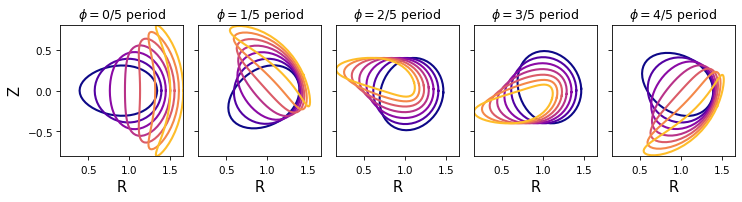

In [4]:
n_interpolations = 7

lambda_values = np.linspace(-0.3, 1.3, n_interpolations)
surfaces = []

for lam in lambda_values:
    interpolated_surface = SurfaceRZFourier(mpol = precise_QA.mpol, ntor = precise_QA.ntor)
    interpolated_surface.x = interpolate_coefficients(QA_coldstart.x, precise_QA.x, lam)
    surfaces.append(interpolated_surface)

labels = [f"λ={lam:.2f}" for lam in lambda_values]

fig, ax = plot_boundaries(
    surfaces=surfaces,
    labels=labels,dpi= 75,
    nphi=5, ntheta=51,
    xlabel_fontsize=14, ylabel_fontsize=14,
    lw=2, legend_kw={'loc': 'upper right'},
    ls=['-'] * len(surfaces),
    legend=False,
    # gif_path="talk_slide_5_1d_interpolation.gif"
)
plt.show()

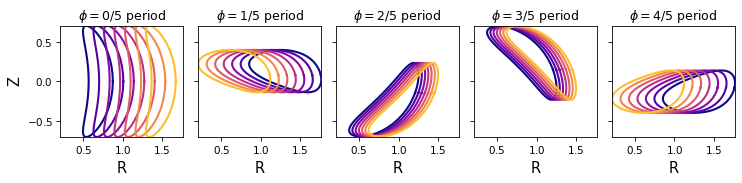

In [5]:
n_interpolations = 7
rbc01_values = np.linspace(-0.2, 0.2, n_interpolations)

surfaces = []

for rbc01 in rbc01_values:
    interpolated_surface = SurfaceRZFourier(mpol = precise_QA.mpol, ntor = precise_QA.ntor)
    interpolated_surface.nfp = precise_QA.nfp
    interpolated_surface.x = precise_QA.x
    interpolated_surface.set_rc(0,1,rbc01)
    surfaces.append(interpolated_surface)

labels = [f"λ={lam:.2f}" for lam in lambda_values]

fig, ax = plot_boundaries(
    surfaces=surfaces,
    labels=labels,dpi= 75,
    nphi=5, ntheta=51,
    xlabel_fontsize=14, ylabel_fontsize=14,
    lw=2, legend_kw={'loc': 'upper right'},
    ls=['-'] * len(surfaces),
    legend=False,
    # gif_path="talk_slide_5_1d_rbc_interpolation.gif"
)
plt.show()

In [6]:
n_interpolations = 101

lambda_values = np.linspace(-0.3, 1.3, n_interpolations)
vmecs = []

for lam in lambda_values:
    vmec_instance = Vmec(verbose=False)
    
    interpolated_surface = SurfaceRZFourier(mpol = precise_QA.mpol, ntor = precise_QA.ntor)
    interpolated_surface.nfp = 2
    interpolated_surface.x = interpolate_coefficients(QA_coldstart.x, precise_QA.x, lam)

    vmec_instance.boundary= interpolated_surface
    vmec_instance.indata.nfp = 2
    vmec_instance.indata.mpol, vmec_instance.indata.ntor = 5, 5 
    vmecs.append(vmec_instance)
    


In [7]:
from simsopt.mhd.vmec_diagnostics import QuasisymmetryRatioResidual
from simsopt.objectives.least_squares import LeastSquaresProblem

radii = [0.05, 0.25, 0.5, 0.75, 1.0]

num_surfaces = 50  
all_surface_levels = np.linspace(0, 1, num_surfaces)
all_surface_levels = radii = [0.05, 0.25, 0.5, 0.75, 1.0]

J_dict = {f"J_{str(radius).replace('.', 'p')}": [] for radius in radii}
J_dict["J_all_surfaces"] = []  
qs_dict = {f"qs_{str(radius).replace('.', 'p')}": [] for radius in radii}
qs_dict["qs_all_surfaces"] = []  

for vmec_instance in vmecs:
    for radius in radii:
        qs = QuasisymmetryRatioResidual(vmec_instance, [radius], 
                         helicity_m=1, helicity_n=0)
        prob = LeastSquaresProblem.from_tuples([(vmec_instance.mean_iota, 0.42, 1),
                                            (qs.residuals, 0, 1)])
        qs_variable_name = f"qs_{str(radius).replace('.', 'p')}"
        J_variable_name = f"J_{str(radius).replace('.', 'p')}"
        J_dict[J_variable_name].append(prob.objective())
        qs_dict[qs_variable_name].append(qs.total())

    qs_all = QuasisymmetryRatioResidual(vmec_instance, all_surface_levels, helicity_m=1, helicity_n=0)
    prob_all = LeastSquaresProblem.from_tuples([(vmec_instance.mean_iota, 0.42, 1),
                                                (qs_all.residuals, 0, 1)])
    J_dict["J_all_surfaces"].append(prob_all.objective())
    qs_dict["qs_all_surfaces"].append(qs_all.total())



In [8]:
import os
import glob

patterns = ["input.*", "wout_*", "threed1.*", "parvmecinfo.txt"]

for pattern in patterns:
    for file_path in glob.glob(pattern):
        try:
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        except OSError as e:
            print(f"Error deleting {file_path}: {e}")

Deleted: input.default_000_000000
Deleted: wout_default_000_000000.nc
Deleted: threed1.default
Deleted: parvmecinfo.txt


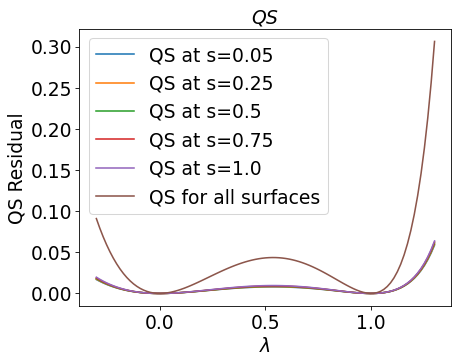

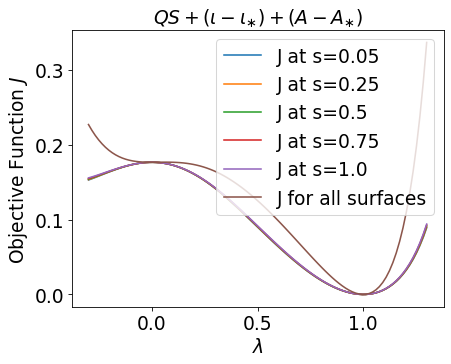

In [9]:
font_size= 18
plt.figure(dpi=75)  # Set the DPI value here

for radius in radii:
    label = f'QS at s={radius}'
    variable_name = f"qs_{str(radius).replace('.', 'p')}"
    plt.plot(lambda_values, qs_dict[variable_name], label=label)

plt.plot(lambda_values, qs_dict["qs_all_surfaces"], label="QS for all surfaces")
plt.xlabel(r'$\lambda$', fontsize=font_size)
plt.ylabel('QS Residual', fontsize=font_size)
plt.title(r'$QS$', fontsize=font_size)
plt.legend(fontsize=font_size)

plt.tick_params(axis='x', labelsize=font_size) 
plt.tick_params(axis='y', labelsize=font_size) 
plt.show()

# Js
font_size= 18
plt.figure(dpi=75)  # Set the DPI value here

for radius in radii:
    label = f'J at s={radius}'
    variable_name = f"J_{str(radius).replace('.', 'p')}"
    plt.plot(lambda_values, J_dict[variable_name], label=label)

plt.plot(lambda_values, J_dict["J_all_surfaces"],label="J for all surfaces")

plt.xlabel(r'$\lambda$', fontsize=font_size)
plt.ylabel('Objective Function $J$', fontsize=font_size)
plt.title(r'$QS + (\iota-\iota_{\ast}) +  (A-A_{\ast})$', fontsize=font_size)
plt.legend(fontsize=font_size)

plt.tick_params(axis='x', labelsize=font_size)  
plt.tick_params(axis='y', labelsize=font_size)  
plt.show()